In [1]:
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

from tsprial.forecasting import ForecastingCascade, ForecastingChain

## data

In [11]:
def gen_randomwalk(timesteps, noise, is_print: bool = False, is_plot: bool = False):
    """
    随机游走
    """
    y = np.random.normal(0, noise, (timesteps,))
    series = y.cumsum()
    if is_print:
        print(series)

    if is_plot:
        plt.figure(figsize = (12, 6))
        plt.plot(series)
        plt.show()

    return series


def gen_sinusoidal(timesteps, amp, freq, noise):
    """
    正弦曲线
    """
    X = np.arange(timesteps)
    e = np.random.normal(0, noise, (timesteps,))
    y = amp * np.sin(X * (2 * np.pi / freq)) + e

    return y


def gen_ts(timesteps, amp, freq, noise, random_state = 0):
    """
    时间序列数据
    """
    np.random.seed(random_state)
    
    if isinstance(freq, (int, float)):
        seas = gen_sinusoidal(timesteps = timesteps, amp = amp, freq = freq, noise = noise)
    elif np.iterable(freq) and not isinstance(freq, str):
        seas = np.zeros(timesteps)
        for f in freq:
            if isinstance(f, (int,float)):
                seas += gen_sinusoidal(timesteps = timesteps, amp = amp, freq = f, noise = noise)
            else:
                raise ValueError("freq not understood.")
    else:
        raise ValueError("freq not understood.")
    
    rw = gen_randomwalk(timesteps = timesteps, noise = 1)
    X = np.linspace(0, 10, timesteps).reshape(-1, 1)
    X = np.power(X, [1, 2])
    trend = LinearRegression().fit(X, rw).predict(X)
    
    return seas + trend

### data gene

(4000, 100)
                         ts_0      ts_1       ts_2       ts_3       ts_4  \
2020-01-01 00:00:00 -5.922228 -3.092053   4.041596  57.290239  35.336967   
2020-01-01 01:00:00 -3.539183 -7.904153  16.484322  49.540020  33.285386   
2020-01-01 02:00:00 -4.774958 -4.061164  11.248265  53.116343  33.504650   
2020-01-01 03:00:00  6.133659 -1.926337  19.892137  44.524964  39.352399   
2020-01-01 04:00:00 -4.943660  7.090062  12.007767  54.032444  36.369269   

                          ts_5       ts_6       ts_7       ts_8       ts_9  \
2020-01-01 00:00:00  -2.213625  13.915080 -16.069439  12.323470   1.168822   
2020-01-01 01:00:00   4.761815  13.553307 -24.396472  16.421555  11.029633   
2020-01-01 02:00:00  15.852302  18.238853 -24.566231  11.019036  -3.147384   
2020-01-01 03:00:00   8.237611  13.371042 -10.187197  16.846366   8.395923   
2020-01-01 04:00:00  15.227063   9.782949 -14.765493  14.531667  10.413457   

                     ...      ts_90      ts_91      ts_92     

<AxesSubplot:>

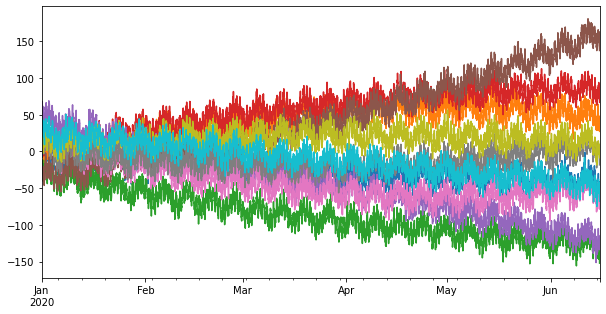

In [15]:
n_series = 100
timesteps = 4000

df = {}
for i in range(n_series):
    df[f"ts_{i}"] = gen_ts(
        timesteps,
        amp = 10,
        freq = [24, 24 * 7],
        noise = 4,
        random_state = i,
    )
df = pd.DataFrame(
    df, 
    index = pd.date_range("2020-01-01", periods = timesteps, freq = "H"),
)
print(df.shape)
print(df.head())
df.sample(n = 10, axis = 1, random_state = 33).plot(legend = False, figsize = (10, 5))

### data split

In [17]:
y_train, y_test = train_test_split(df, test_size = 24 * 7, shuffle = False)
y_train.shape, y_test.shape

((3832, 100), (168, 100))

## metric

In [2]:
def get_metrics(model, X, y, metrics = None):
    """
    STORE FORECASTING METRICS

    Args:
        model (_type_): _description_
        X (_type_): _description_
        y (_type_): _description_
        metrics (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    score = {
        "mse": [model.score(X, y, scoring = "mse")],
        "mae": [model.score(X, y, scoring = "mae")],
        "mape": [model.score(X, y, scoring = "mape")],
        "rmse": [model.score(X, y, scoring = "rmse")],
    }
    if metrics is not None:
        for metric, s in score.items():
            metrics[metric].extend(s)
    else:
        metrics = score
    
    return metrics

## 递归预测

In [33]:
supports = []
model = ForecastingCascade(
    make_pipeline(
        SelectFromModel(
            Ridge(),
            threshold = "median",
            max_features = 72,
        ),
        Ridge(),
    ),
    lags = range(1, 24 * 7 + 1),
    use_exog = False,
)

for c in tqdm(df.columns):
    model.fit(None, y_train[c])
    supports.append(model.estimator_["selectfrommodel"].get_support(indices = True))
supports = np.asarray(supports)
print(supports.shape)
supports

100%|██████████████████████████████████| 100/100 [00:01<00:00, 75.75it/s]

(100, 72)


array([[  0,   1,   2, ..., 161, 163, 164],
       [  0,   1,   3, ..., 159, 160, 163],
       [  0,   1,   3, ..., 164, 165, 167],
       ...,
       [  1,   2,   5, ..., 163, 165, 166],
       [  0,   1,   2, ..., 164, 165, 166],
       [  0,   1,   4, ..., 146, 164, 165]])

In [32]:
results = {}

def recursive_forecasting(lags):
    times = []
    metrics = None
    forecast_horizon = np.arange(24 * 7)
    for i, c in tqdm(enumerate(df.columns), total = n_series):
        model = ForecastingCascade(
            Ridge(),
            lags = lags,
            use_exog = False,
        )
        model.fit(None, y_train[c])
        init = time.time()
        pred = model.predict(forecast_horizon)
        total_time = time.time() - init
        times.append(total_time)
        metrics = get_metrics(model, forecast_horizon, y_test[c], metrics)
    metrics = {
        m: np.mean(s) for m, s in metrics.items()
    }
    metrics["total time"] = np.sum(times)
    metrics["std time"] = np.std(times)
    results["recursive full"] = metrics
    print(metrics)